# Computer Vision - Assignment 2 - Deep Learning for Computer Vision

#### 10 points   |   Due date: November 26, 23:59   |   Submission site: https://pradogrado2324.ugr.es/

### Student's Full Name: <mark>DAVID MUÑOZ SÁNCHEZ</mark>

The goal of this assignment is to learn how to implement and use Convolutional Neural Networks using the fastai library (https://docs.fast.ai/).

In [18]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

fastcore version 1.5.29 installed
fastai version 2.7.13 installed


In [19]:
# Function to display evaluation metrics

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Exercise  3: Model transfer and fine-tuning with ResNet18 for the Caltech-UCSD Birds-200-2011 database (3.5 points)**
<font color='blue'>In this exercise we will work with the Caltech-UCSD Birds-200-2011 dataset (https://www.vision.caltech.edu/datasets/cub_200_2011/). This dataset consists of 11,788 images of 200 bird species. It has 200 classes, with 5,994 for training and 5,794 for testing. Again, 10% of the training set will be left for validation. Read the dataset using the provided functions.

<font color='blue'>We will use the ResNet18 network model already pre-trained with ImageNet, it can be downloaded from the fastai Model repository. You have to compare the performance of the following models and training strategies:

<font color='blue'>1. Use ResNet18 as a feature extractor for the Caltech-UCSD Birds-200-2011 dataset under three different scenarios:

>  <font color='blue'>1.1. Remove the final fully-connected (FC) layer of ResNet18, replace it by a FC layer of the dimensionality of the new problem, and train the new weights of this FC layer (while keeping frozen the remaining weights in the network).

> <font color='blue'>1.2. Instead of a single FC layer, employ the head introduced by default in fastai (see https://wandb.ai/capecape/imagenette_timm/reports/Checking-Out-the-New-fastai-timm-Integration--VmlldzoxOTMzNzMw and https://docs.fast.ai/vision.learner.html#head-and-model). Train these new weights (while keeping frozen the remaining weights in the network).

> <font color='blue'>1.3. Create your own head, combining all types of blocks you want (convolutional, FC layers,...). Train all these new weights (while keeping frozen the remaining weight in the network).

<font color='blue'>2. Make a fine-tuning of the entire ResNet18 network. Remember that the number of epochs for fine-tuning must be small.

<font color='blue'>3. Train from scratch the entire ResNet18 network. Remember that the number of epochs for fine-tuning must be VERY small.





---



---



---

First, we need to read the data from the URL

In [20]:
# https://docs.fast.ai/data.external.html
path = untar_data(URLs.CUB_200_2011)

In [21]:
print(path)
print(path.ls())
print((path/'CUB_200_2011/').ls())
train_test_split = np.loadtxt('/root/.fastai/data/CUB_200_2011/CUB_200_2011/train_test_split.txt',dtype=int)
# !cat /root/.fastai/data/CUB_200_2011/CUB_200_2011/train_test_split.txt

print('Number of testing examples: ', (train_test_split[:,1]== 0).sum())
print('Number of training examples: ', (train_test_split[:,1]== 1).sum())
print(train_test_split)


/root/.fastai/data/CUB_200_2011
[Path('/root/.fastai/data/CUB_200_2011/test'), Path('/root/.fastai/data/CUB_200_2011/train'), Path('/root/.fastai/data/CUB_200_2011/attributes.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011')]
[Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/train_test_split.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/README'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/image_class_labels.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/bounding_boxes.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/attributes'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/classes.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images.txt'), Path('/root/.fastai/data/CUB_200_2011/CUB_200_2011/parts')]
Number of testing examples:  5794
Number of training examples:  5994
[[    1     0]
 [    2     1]
 [    3     0]
 ...
 [11786     0]
 [11787     1]
 [11788    

In [22]:
with open('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images.txt') as file:
    images_list = file.readlines()
    images_list = [line.rstrip() for line in images_list]
print(images_list)

['1 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg', '2 001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg', '3 001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg', '4 001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg', '5 001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg', '6 001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg', '7 001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg', '8 001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg', '9 001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg', '10 001.Black_footed_Albatross/Black_Footed_Albatross_0025_796057.jpg', '11 001.Black_footed_Albatross/Black_Footed_Albatross_0023_796059.jpg', '12 001.Black_footed_Albatross/Black_Footed_Albatross_0086_796062.jpg', '13 001.Black_footed_Albatross/Black_Footed_Albatross_0049_796063.jpg', '14 001.Black_footed_Albatross/Black_Footed_Albatross_0006_796065.jpg', '15 001.Black_footed_Albatr

In [23]:
classes = (path/'CUB_200_2011/images/').ls()
print('Number of examples per class')
for i in range(len(classes)):
  print(len(classes[i].ls()), end=" ")


Number of examples per class
60 60 60 60 60 60 58 60 56 59 60 60 60 60 60 60 60 60 60 59 60 60 59 60 50 58 60 60 60 59 60 60 48 60 57 60 59 60 60 45 60 60 60 60 60 59 50 60 60 60 58 60 58 60 60 60 60 60 60 41 60 60 60 60 59 59 60 60 60 60 56 60 60 60 60 59 60 60 60 58 60 60 60 59 60 60 60 60 60 50 60 60 60 60 60 60 59 60 60 60 59 60 60 59 52 60 60 59 60 59 60 59 60 59 60 60 60 60 59 60 60 60 60 59 59 60 50 60 60 60 51 60 60 60 60 60 44 60 60 59 53 60 49 60 58 60 60 60 60 60 60 57 60 60 59 59 60 60 60 60 60 60 59 60 60 60 60 60 60 59 60 60 53 60 60 59 60 60 59 60 59 59 59 60 60 60 60 60 60 60 60 60 60 60 56 60 60 60 53 59 

In [24]:
# Now we have in images_list the list with all the images, and in train_test_split which ones belong to training (1) or test (0)
# We are going to create two folders: one train and another test, and we are going to put the corresponding images inside
print(path)
import shutil, os
if os.path.isdir('/root/.fastai/data/CUB_200_2011/train'):
  shutil.rmtree('/root/.fastai/data/CUB_200_2011/train')
if os.path.isdir('/root/.fastai/data/CUB_200_2011/test'):
  shutil.rmtree('/root/.fastai/data/CUB_200_2011/test')

shutil.copytree('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images','/root/.fastai/data/CUB_200_2011/train')
shutil.copytree('/root/.fastai/data/CUB_200_2011/CUB_200_2011/images','/root/.fastai/data/CUB_200_2011/test')


/root/.fastai/data/CUB_200_2011


'/root/.fastai/data/CUB_200_2011/test'

In [25]:
print((path/'train').ls())
print(len((path/'train').ls()))

[Path('/root/.fastai/data/CUB_200_2011/train/102.Western_Wood_Pewee'), Path('/root/.fastai/data/CUB_200_2011/train/165.Chestnut_sided_Warbler'), Path('/root/.fastai/data/CUB_200_2011/train/047.American_Goldfinch'), Path('/root/.fastai/data/CUB_200_2011/train/046.Gadwall'), Path('/root/.fastai/data/CUB_200_2011/train/138.Tree_Swallow'), Path('/root/.fastai/data/CUB_200_2011/train/044.Frigatebird'), Path('/root/.fastai/data/CUB_200_2011/train/003.Sooty_Albatross'), Path('/root/.fastai/data/CUB_200_2011/train/174.Palm_Warbler'), Path('/root/.fastai/data/CUB_200_2011/train/022.Chuck_will_Widow'), Path('/root/.fastai/data/CUB_200_2011/train/196.House_Wren'), Path('/root/.fastai/data/CUB_200_2011/train/199.Winter_Wren'), Path('/root/.fastai/data/CUB_200_2011/train/038.Great_Crested_Flycatcher'), Path('/root/.fastai/data/CUB_200_2011/train/093.Clark_Nutcracker'), Path('/root/.fastai/data/CUB_200_2011/train/045.Northern_Fulmar'), Path('/root/.fastai/data/CUB_200_2011/train/059.California_Gull'

In [26]:
import os
for i in range(len(train_test_split)):
    if train_test_split[i,1]==0: #test image
       os.remove(path/'train'/images_list[i].rsplit(' ')[1]) #we remove it from train
    if train_test_split[i,1]==1: #train image
      os.remove(path/'test'/images_list[i].rsplit(' ')[1]) #we remove it from test

In [27]:
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))


Total training images:  5994
Total test images:  5794


## <font color='blue'> 3.1.1 Train single FC layer included in the head

In [28]:
doc(create_vision_model)
doc(vision_learner)

Para comenzar con este último apartado de la práctica, lo primero será discutir el uso de las dos funciones anteriores. Se nos pide en los tres apartados siguientes crear modelos basados en ResNet18 pero añadiendo una cabecera, es decir, la última capa.

Por ello, es interesante el uso de las funciones anteriores, que logran los efectos que deseamos.

La principal diferencia entre ambas es que la primera crea un nn.Sequential y la segunda un learner.

En cuanto a la primera, según la documentación: The model is cut according to cut and it may be pretrained, in which case, the proper set of weights is downloaded then loaded. init is applied to the head of the model, which is either created by create_head (with lin_ftrs, ps, concat_pool, bn_final, lin_first and y_range) or is custom_head.


La segunda, dice lo siguiente: The model is built from arch using the number of final activations inferred from dls if possible (otherwise pass a value to n_out). It might be pretrained and the architecture is cut and split using the default metadata of the model architecture (this can be customized by passing a cut or a splitter).

If normalize and pretrained are True, this function adds a Normalization transform to the dls (if there is not already one) using the statistics of the pretrained model. That way, you won’t ever forget to normalize your data in transfer learning.

All other arguments are passed to Learner.

Es decir, de esta segunda, hay muchos argumentos iguales que los que se discutieron para el Learner.

Dado el gran número de argumentos, se irán discutiendo los que se vayan usando en la práctica y no se dejen por defecto.


Para comenzar este primer apartado, se crea un DataBlock, y se fuerza a que todas las imágnees sean 224x224, tal y como las de ImageNet, que es con lo que se ha entrenado ResNet18. Además, se añade la normalización según las stats de Imagenet.

Se ha optado por un BS de 32 para hacerlo igual que en la primera parte de la práctica. No obstante, se probarán otros.

In [29]:
db_train= DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 33),
    get_y = parent_label,
    item_tfms = Resize(224), # so our images have the same size as ImageNet images (the dataset in which ResNet18 was pretrained on)
    batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
)
dls  = db_train.dataloaders(path/'train', bs=32)

#Custom head
num_classes = 200
head = nn.Sequential(Flatten(), nn.Linear(25088, num_classes))

#Resnet with custom head, preentrenado por defecto
model = create_vision_model(resnet18, num_classes, custom_head=head)


Para saber cuántas características debería tener la capa lineal, se puede proceder haciendo una cabecera solo con Flatten y mostrando la información con Summary, no hace falta calcularlo todo.

In [30]:
doc(Learner.freeze_to)

Esta función también nos servirá de mucha ayuda, puesto que congela el entrenamiento de los grupos de parámetros hasta n. En este caso, si ponemos n = 1, se congelarán todos los grupos menos el último, que es nuestra cabecer.

Tras usar freeze_to con 1, saltaba un aviso de que se iba a congelar todo el modelo porque solo había un grupo de parámetros. Si se imprime con print(learner.model), se puede observar que hay dos grandes grupos, pero es necesario pasar un splitter al Learner para que el freeze se haga correctamente.

In [31]:
# Freeze the weights of the ResNet18 body
def custom_splitter(model):
    #Un grupo va del 0.0 al 0.7 y otro todos los que empiecen por 1, que es nuestra cabecera.
    return [params(model[0][:8]), params(model[1][:])]



In [32]:
learn = Learner(dls, model, metrics=accuracy, splitter = custom_splitter, train_bn = False)
learn.freeze_to(1)
for name, param in learn.model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')


0.0.weight: requires_grad=False
0.1.weight: requires_grad=False
0.1.bias: requires_grad=False
0.4.0.conv1.weight: requires_grad=False
0.4.0.bn1.weight: requires_grad=False
0.4.0.bn1.bias: requires_grad=False
0.4.0.conv2.weight: requires_grad=False
0.4.0.bn2.weight: requires_grad=False
0.4.0.bn2.bias: requires_grad=False
0.4.1.conv1.weight: requires_grad=False
0.4.1.bn1.weight: requires_grad=False
0.4.1.bn1.bias: requires_grad=False
0.4.1.conv2.weight: requires_grad=False
0.4.1.bn2.weight: requires_grad=False
0.4.1.bn2.bias: requires_grad=False
0.5.0.conv1.weight: requires_grad=False
0.5.0.bn1.weight: requires_grad=False
0.5.0.bn1.bias: requires_grad=False
0.5.0.conv2.weight: requires_grad=False
0.5.0.bn2.weight: requires_grad=False
0.5.0.bn2.bias: requires_grad=False
0.5.0.downsample.0.weight: requires_grad=False
0.5.0.downsample.1.weight: requires_grad=False
0.5.0.downsample.1.bias: requires_grad=False
0.5.1.conv1.weight: requires_grad=False
0.5.1.bn1.weight: requires_grad=False
0.5.1

La capa añadida son las que empiezan por 1 y como se ve, requires_grad = True, eso significa que se actulizarán los pesos, no está congelada.

Otro hecho reseñable es que, si no se pone train_bn a False en learner, las capas de Batch Normalization no ponen requires_grad a False. Como en el ejercicio se pide congelar todo, se pone a False. No obstante, en el modelo más prometedor, se probará a dejar a True.

SuggestedLRs(valley=7.585775892948732e-05)

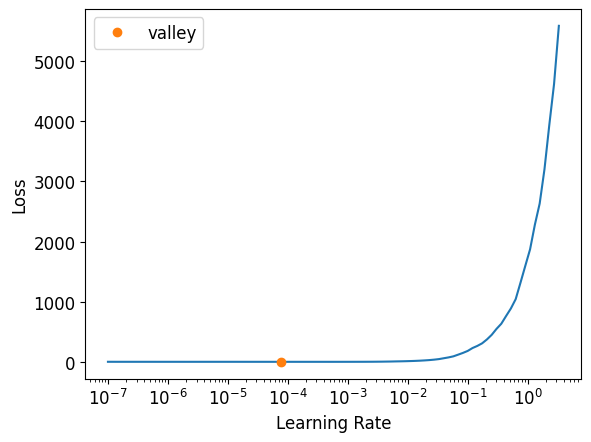

In [33]:
learn.lr_find(stop_div=False)

Parece adecuado un LR = $10^{-3}$. A partir de ahí, el modelo empieza a diverger. Se usará Early Stopping con paciencia 5 para no demorar demasiado el entrenamiento si la curva de la pérdida en validación no se comporta bien.

In [34]:
es = EarlyStoppingCallback (min_delta=0.01, patience=5)
learn.fit_one_cycle(30, lr_max = 10**-3, cbs = es)

epoch,train_loss,valid_loss,accuracy,time
0,4.611170,3.863714,0.242070,00:35
1,2.506120,3.963309,0.347245,00:36
2,2.849346,6.477560,0.295493,00:38
3,4.524744,10.466087,0.287145,00:36
4,5.854475,13.736542,0.325543,00:35
5,6.157803,18.857317,0.312187,00:35


No improvement since epoch 0: early stopping


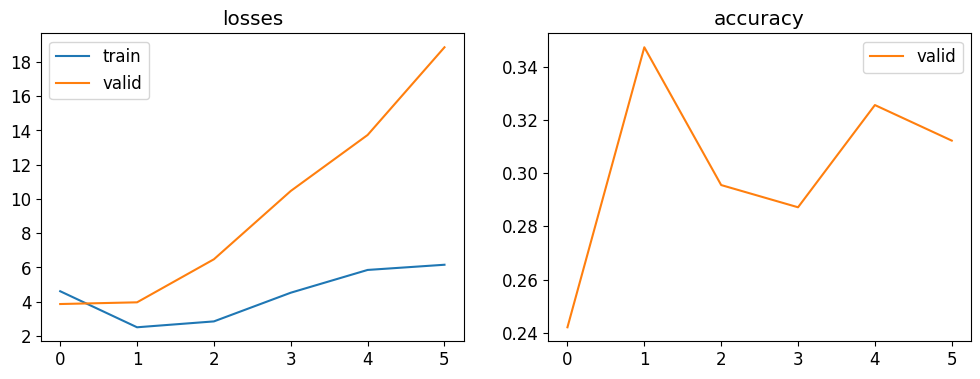

In [35]:
learn.recorder.plot_metrics()

El modelo no se comporta bien. No minimiza el error en Train y en Validación se dispara el error.

## <font color='blue'> 3.1.2 Train head included by default in fastai

Para obtener la cabecera por defecto en FastAI es tan simple como usar su función create_head con todos los parámetros que se puedan por defecto. Esta forma de proceder es exactamente igual que si no hubieramos tocado nada en ResNet18. No obstante, con fin de entender como es la cabecera y hacerlo paso a paso, se ha optado por crearla y así explorar también la función de create_head.

In [36]:
doc(create_head)

Se dejará todo por defecto excepto nf y n_out, que se pondrán a 512 y 200, respectivamente.

200 porque es el número de clases.

512 porque se va a realizar un AdaptiveConcatPool2d, es decir, una concatenación de un AdaptiveAVGPool y AdaptiveMaxPool.

Estas operaciones, reducen las imágenes a un píxel por canal. Si vemos el summary del apartado anterior, vemos como antes de la cabecera, se cuenta con 512 canales.

La función, después, trabajará con 1024, ya que el faltten tras la concatenación de la que se hablaba, resulta en un vector de 512 + 512.

In [37]:
# Create a custom head for ResNet18
num_classes = 200
head = create_head(512, 200)

print(head)
# Create a ResNet18 model with the custom head
model = create_vision_model(resnet18, num_classes, custom_head=head)

# Create a Fastai Learner
learn2 = Learner(dls, model, metrics=accuracy, splitter = custom_splitter, train_bn = False)

learn2.summary()

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=200, bias=False)
)


Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

Se procede como antes para congelar todo menos la cabecera añadida.

In [38]:

# Freeze the weights of the ResNet18 body
learn2.freeze_to(1)

for name, param in learn2.model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')


0.0.weight: requires_grad=False
0.1.weight: requires_grad=False
0.1.bias: requires_grad=False
0.4.0.conv1.weight: requires_grad=False
0.4.0.bn1.weight: requires_grad=False
0.4.0.bn1.bias: requires_grad=False
0.4.0.conv2.weight: requires_grad=False
0.4.0.bn2.weight: requires_grad=False
0.4.0.bn2.bias: requires_grad=False
0.4.1.conv1.weight: requires_grad=False
0.4.1.bn1.weight: requires_grad=False
0.4.1.bn1.bias: requires_grad=False
0.4.1.conv2.weight: requires_grad=False
0.4.1.bn2.weight: requires_grad=False
0.4.1.bn2.bias: requires_grad=False
0.5.0.conv1.weight: requires_grad=False
0.5.0.bn1.weight: requires_grad=False
0.5.0.bn1.bias: requires_grad=False
0.5.0.conv2.weight: requires_grad=False
0.5.0.bn2.weight: requires_grad=False
0.5.0.bn2.bias: requires_grad=False
0.5.0.downsample.0.weight: requires_grad=False
0.5.0.downsample.1.weight: requires_grad=False
0.5.0.downsample.1.bias: requires_grad=False
0.5.1.conv1.weight: requires_grad=False
0.5.1.bn1.weight: requires_grad=False
0.5.1

SuggestedLRs(valley=0.0012022644514217973)

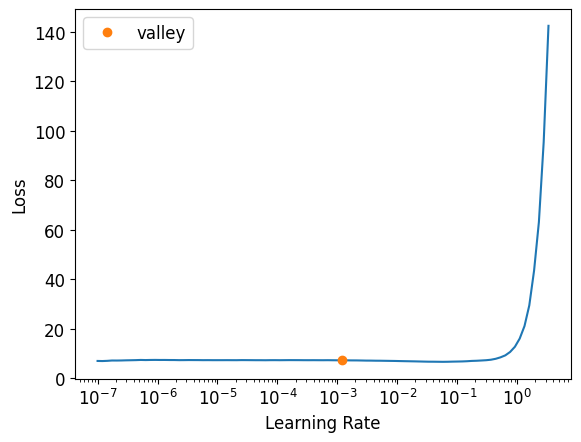

In [39]:
learn2.lr_find(stop_div=False)

Parece razonable usar un LRMax de $10^{-3}$.

In [40]:
es = EarlyStoppingCallback (min_delta=0.01, patience=5)
learn2.fit_one_cycle(30, lr_max = 10**-3, cbs = es)

epoch,train_loss,valid_loss,accuracy,time
0,6.925414,5.692197,0.013356,00:35
1,5.950305,4.690958,0.071786,00:36
2,4.714188,3.443815,0.265442,00:36
3,3.497369,2.659170,0.373957,00:36
4,2.655104,2.240996,0.427379,00:35
5,2.078591,1.975163,0.497496,00:36
6,1.771293,1.858151,0.517529,00:37
7,1.486348,1.768283,0.522538,00:36
8,1.322062,1.746601,0.544240,00:35
9,1.191677,1.724557,0.549249,00:36


No improvement since epoch 11: early stopping


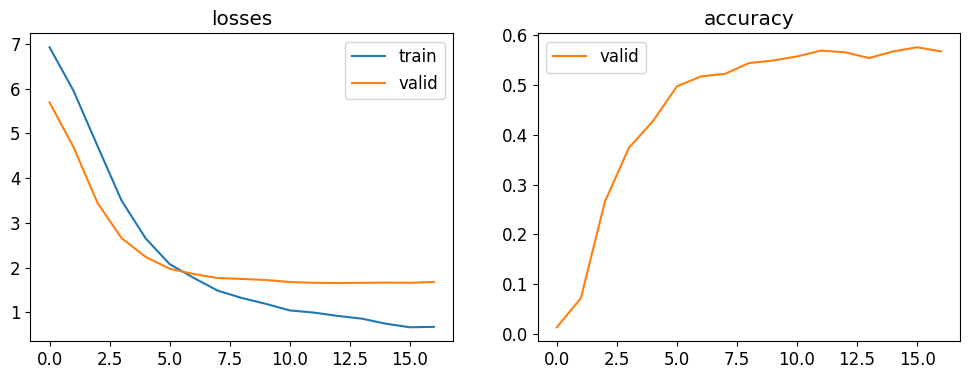

In [41]:
learn2.recorder.plot_metrics()

Este nuevo modelo ha obtenido más accuracy en validación aunque hace overfitting. El anterior, en las primeras épocas, se comportó de manera extraña y este no, así que de momento se optará por esta cabecera para los siguientes experimentos. Además, se logra un mayor accuracy en validación.


## <font color='blue'> 3.1.3. Train new custom head (including convolutional layers, FC layers, etc.)

En este caso, como la última capa de Resnet cuenta con 512 canales, se aprovechará parte del modelo final de las tareas 1 y 2. Se realizarán las modificaciones pertinentes para tener en cuenta que tenemos 200 clases en vez de 25.

Además, como ya se usa Dropout, se probará data augmentation para ver si se soluciona el proglema con el overfitting en el ejercicio anterior.

In [42]:
# Create a custom head for ResNet18
num_classes = 200
head1 = nn.Sequential(
    nn.Conv2d(512,1024,3),
    nn.BatchNorm2d(1024),
    nn.ReLU(),

    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(),
    nn.Linear(1024, 500),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(500),
    nn.ReLU(),


    nn.Linear(500, 200),)

num_classes = 200
head2 = create_head(512, 200)

####datablock y dataloader para data augmentation
db_train_aug= DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 33),
    get_y = parent_label,
    item_tfms = Resize(224), # so our images have the same size as ImageNet images (the dataset in which ResNet18 was pretrained on)
    batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats), *aug_transforms(flip_vert = True)]
)
dls_aug  = db_train_aug.dataloaders(path/'train', bs=32)
# Create a ResNet18 model with the custom head
model1 = create_vision_model(resnet18, num_classes, custom_head=head1)
model2 = create_vision_model(resnet18, num_classes, custom_head=head2)
# Create a Fastai Learner
learn3 = Learner(dls, model1, metrics=accuracy, train_bn = False, splitter = custom_splitter)
learn4 = Learner(dls_aug, model2, metrics=accuracy, train_bn = False, splitter = custom_splitter)

print(learn3.summary())
print(learn4.summary())

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

Se procede como antes para la congelación.

In [43]:
learn3.freeze_to(1)

for name, param in learn3.model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')

0.0.weight: requires_grad=False
0.1.weight: requires_grad=False
0.1.bias: requires_grad=False
0.4.0.conv1.weight: requires_grad=False
0.4.0.bn1.weight: requires_grad=False
0.4.0.bn1.bias: requires_grad=False
0.4.0.conv2.weight: requires_grad=False
0.4.0.bn2.weight: requires_grad=False
0.4.0.bn2.bias: requires_grad=False
0.4.1.conv1.weight: requires_grad=False
0.4.1.bn1.weight: requires_grad=False
0.4.1.bn1.bias: requires_grad=False
0.4.1.conv2.weight: requires_grad=False
0.4.1.bn2.weight: requires_grad=False
0.4.1.bn2.bias: requires_grad=False
0.5.0.conv1.weight: requires_grad=False
0.5.0.bn1.weight: requires_grad=False
0.5.0.bn1.bias: requires_grad=False
0.5.0.conv2.weight: requires_grad=False
0.5.0.bn2.weight: requires_grad=False
0.5.0.bn2.bias: requires_grad=False
0.5.0.downsample.0.weight: requires_grad=False
0.5.0.downsample.1.weight: requires_grad=False
0.5.0.downsample.1.bias: requires_grad=False
0.5.1.conv1.weight: requires_grad=False
0.5.1.bn1.weight: requires_grad=False
0.5.1

SuggestedLRs(valley=0.0006918309954926372)

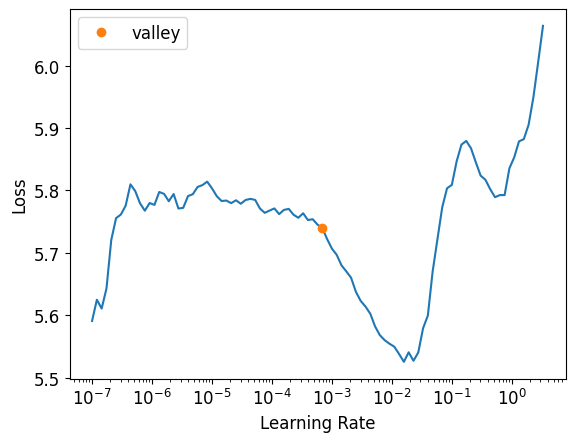

In [44]:
learn3.lr_find(stop_div=False)

Para este learner se usará un LR Max de $10^{-3}$.

In [45]:
learn4.freeze_to(1)
for name, param in learn4.model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')

0.0.weight: requires_grad=False
0.1.weight: requires_grad=False
0.1.bias: requires_grad=False
0.4.0.conv1.weight: requires_grad=False
0.4.0.bn1.weight: requires_grad=False
0.4.0.bn1.bias: requires_grad=False
0.4.0.conv2.weight: requires_grad=False
0.4.0.bn2.weight: requires_grad=False
0.4.0.bn2.bias: requires_grad=False
0.4.1.conv1.weight: requires_grad=False
0.4.1.bn1.weight: requires_grad=False
0.4.1.bn1.bias: requires_grad=False
0.4.1.conv2.weight: requires_grad=False
0.4.1.bn2.weight: requires_grad=False
0.4.1.bn2.bias: requires_grad=False
0.5.0.conv1.weight: requires_grad=False
0.5.0.bn1.weight: requires_grad=False
0.5.0.bn1.bias: requires_grad=False
0.5.0.conv2.weight: requires_grad=False
0.5.0.bn2.weight: requires_grad=False
0.5.0.bn2.bias: requires_grad=False
0.5.0.downsample.0.weight: requires_grad=False
0.5.0.downsample.1.weight: requires_grad=False
0.5.0.downsample.1.bias: requires_grad=False
0.5.1.conv1.weight: requires_grad=False
0.5.1.bn1.weight: requires_grad=False
0.5.1

SuggestedLRs(valley=0.0014454397605732083)

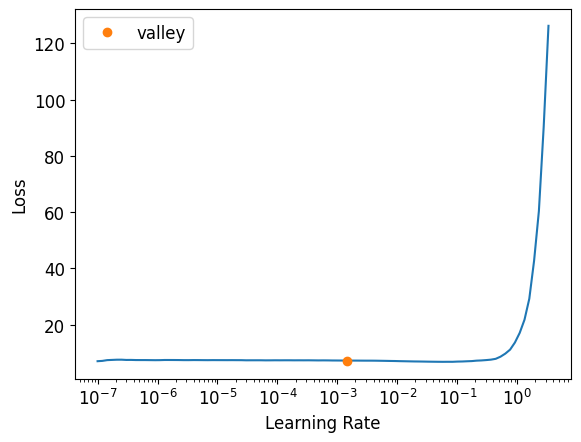

In [46]:
learn4.lr_find(stop_div=False)

Se usará el mismo LR Max.

epoch,train_loss,valid_loss,accuracy,time
0,5.301507,4.901280,0.046745,00:36
1,4.507972,4.200420,0.190317,00:36
2,3.721552,3.531587,0.342237,00:36
3,3.045019,3.017468,0.440735,00:36
4,2.541893,2.682978,0.467446,00:36
5,2.102712,2.390386,0.504174,00:36
6,1.750007,2.151277,0.517529,00:36
7,1.533449,1.982407,0.517529,00:36
8,1.355706,1.859900,0.517529,00:40
9,1.208378,1.787680,0.535893,00:36


No improvement since epoch 13: early stopping


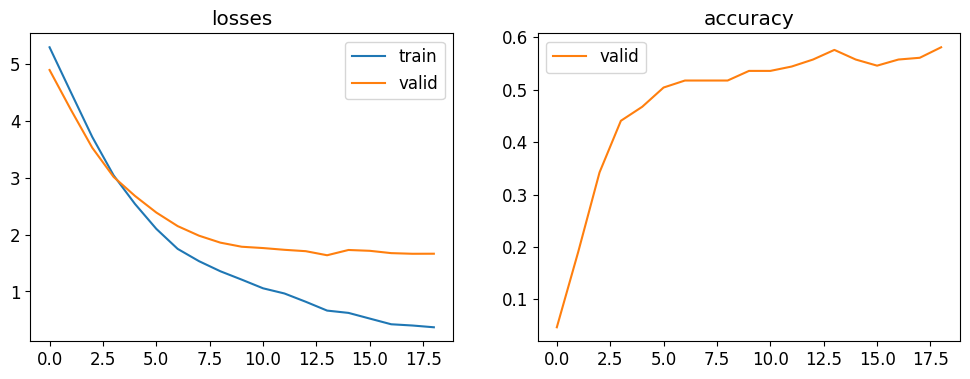

In [47]:
es = EarlyStoppingCallback (min_delta=0.01, patience=5)
learn3.fit_one_cycle(50, lr_max = 10**-3, cbs=[es])
learn3.recorder.plot_metrics()

Se comporta parecido al experimento anterior. El aumento de parámetros hace descartar esta idea.

epoch,train_loss,valid_loss,accuracy,time
0,6.960307,5.614697,0.008347,00:39
1,6.545190,5.102810,0.028381,00:37
2,5.889338,4.369689,0.088481,00:37
3,5.072624,3.593042,0.218698,00:37
4,4.283727,2.914132,0.337229,00:39
5,3.566649,2.459865,0.385643,00:39
6,3.147659,2.193318,0.447412,00:38
7,2.749282,1.973522,0.492487,00:37
8,2.514073,1.871144,0.500835,00:38
9,2.419246,1.826354,0.522538,00:46


No improvement since epoch 26: early stopping


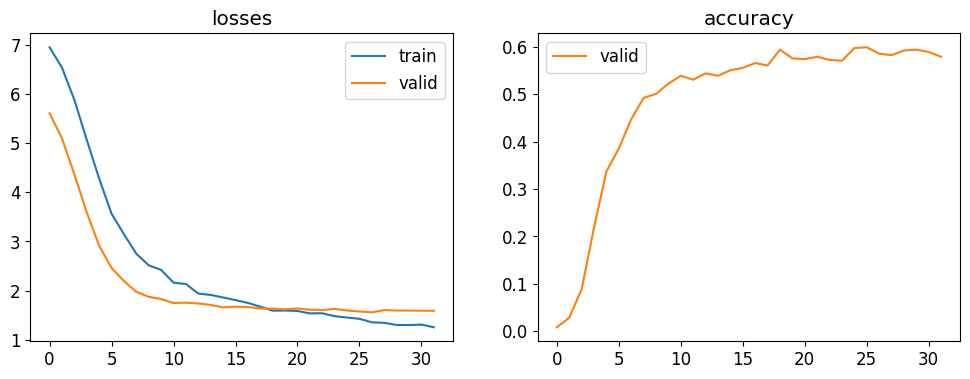

In [48]:
es = EarlyStoppingCallback (min_delta=0.01, patience=5)
learn4.fit_one_cycle(50, lr_max = 10**-3, cbs=[es])
learn4.recorder.plot_metrics()

Con Data Augmentation se soluciona el overfitting del 3.1.2 y se logra un buen accuracy.

Llegados a este punto, y tras descartar la prueba primera y la primera parte de la tercera (3.1.1 y 3.1.3 con el enfoque de las partes 1 y 2 de la práctica) por sus malos resultados, especialmente el primero. En el tercero, se ha logrado buen accuracy pero el incremento de parámetros y el overfitting hace que compense menos que la opción finalmente elegida. Habría que elegir entre la cabecera por defecto y la cabecera por defecto con data augmentation (ambas sin entrenar las capas de BN).

Queda claro que el Data Augmentation soluciona el problema de overfitting del 3.1.2, así que se elige esta cabecera con DataAugmentation en Train.

##PRUEBA DE LA MEJOR CABECERA CON TRAIN BN A TRUE (POR DEFECTO)

A pesar de que se nos dice que tenemos que congelar todo menos la cabecera para entrenar, se va a comprobar si haciendo que se entrenen también las capas de BN que había en ResNet, se mejoran los resultados.

In [49]:
num_classes = 200
head3 = create_head(512, 200)
model3 = create_vision_model(resnet18, num_classes, custom_head=head3)

learn5 = Learner(dls_aug, model3, metrics=accuracy, train_bn = True, splitter = custom_splitter)

learn5.freeze_to(1)

for name, param in learn4.model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')

0.0.weight: requires_grad=False
0.1.weight: requires_grad=False
0.1.bias: requires_grad=False
0.4.0.conv1.weight: requires_grad=False
0.4.0.bn1.weight: requires_grad=False
0.4.0.bn1.bias: requires_grad=False
0.4.0.conv2.weight: requires_grad=False
0.4.0.bn2.weight: requires_grad=False
0.4.0.bn2.bias: requires_grad=False
0.4.1.conv1.weight: requires_grad=False
0.4.1.bn1.weight: requires_grad=False
0.4.1.bn1.bias: requires_grad=False
0.4.1.conv2.weight: requires_grad=False
0.4.1.bn2.weight: requires_grad=False
0.4.1.bn2.bias: requires_grad=False
0.5.0.conv1.weight: requires_grad=False
0.5.0.bn1.weight: requires_grad=False
0.5.0.bn1.bias: requires_grad=False
0.5.0.conv2.weight: requires_grad=False
0.5.0.bn2.weight: requires_grad=False
0.5.0.bn2.bias: requires_grad=False
0.5.0.downsample.0.weight: requires_grad=False
0.5.0.downsample.1.weight: requires_grad=False
0.5.0.downsample.1.bias: requires_grad=False
0.5.1.conv1.weight: requires_grad=False
0.5.1.bn1.weight: requires_grad=False
0.5.1

SuggestedLRs(valley=0.0010000000474974513)

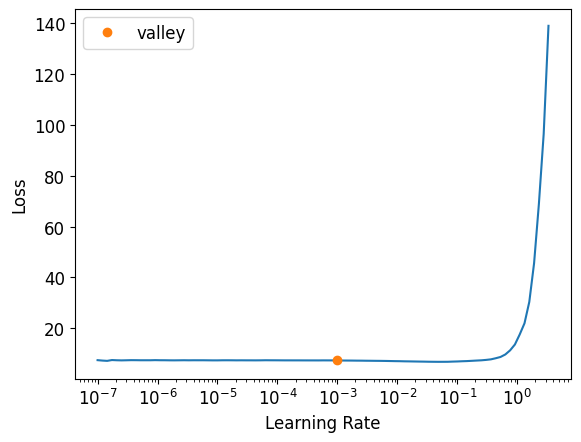

In [50]:
learn5.lr_find(stop_div = False)

Parece lógico usar un lr_max de $10^{-3}$.

In [51]:
learn5.fit_one_cycle(50, lr_max = 10**-3, cbs=[es])


epoch,train_loss,valid_loss,accuracy,time
0,7.062027,5.772257,0.011686,00:40
1,6.584532,5.235838,0.025042,00:40
2,5.906109,4.435524,0.096828,00:39
3,4.993289,3.516232,0.227045,00:39
4,4.105562,2.748203,0.333890,00:41
5,3.332349,2.176561,0.457429,00:38
6,2.739075,1.875509,0.520868,00:39
7,2.373305,1.689252,0.567613,00:40
8,2.166719,1.644933,0.569282,00:40
9,1.949242,1.494139,0.594324,00:39


No improvement since epoch 16: early stopping


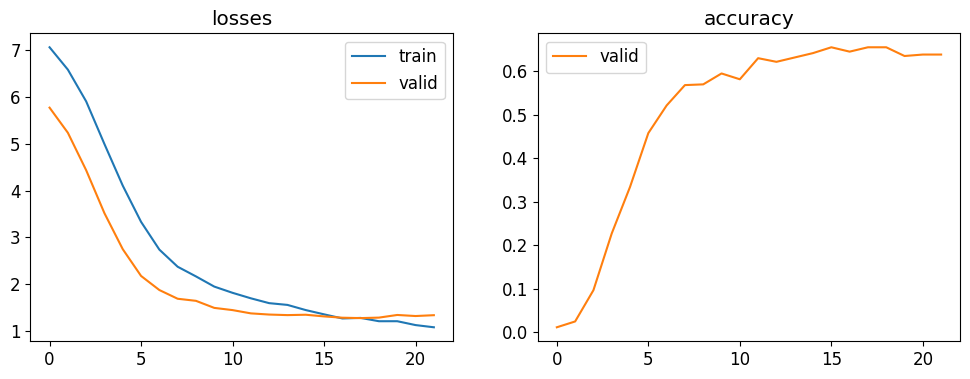

In [52]:
learn5.recorder.plot_metrics()

Se ha logrado mayor Accuracy aunque se produce un poco de overfitting, por lo que en adelante, se permitirá el entrenamiento de las capas de BN.

## <font color='blue'> 3.2. Fine-tuning of all ResNet18 (including the suitable FC layer as output/head)

Para este ejercicio se usará la función fine_tune. Se discutirán los distintos parámetros a continuación:

In [53]:
doc(Learner.fine_tune)



```
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
```



Este es el código fuente de la función. Los parámetros más interesantes y con los que se harán diversas pruebas son:

+ freeze_epochs : es decir, las épocas con la que se va a entrenar el modelo congelado.

+ base_lr: el learning rate con el que se entrena el modelo congelado. Cuando se descongela, el modelo se entrenará con un slice que asignará un lr menor a las primeras capas. Este slice va desde base_lr/2*lr_mult a base_lr/2. Se usa como el LR_Max de fit_one_cycle internamente.

In [54]:
doc(Learner.freeze)

Como internamente fine_tune usa esta función, en el learner se indicará train_bn a true (porque nos ha dado mejores resultados) y habrá que hacer otra vez el custom split.

In [55]:
head1 = create_head(512, 200)
head2 = create_head(512, 200)
head3 = create_head(512, 200)
print(head1)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=200, bias=False)
)


###PRIMER FINE TUNING

In [56]:
learn3 = vision_learner(deepcopy(dls_aug), resnet18, pretrained=True, metrics=accuracy, custom_head = head1, splitter = custom_splitter)

SuggestedLRs(valley=0.0008317637839354575)

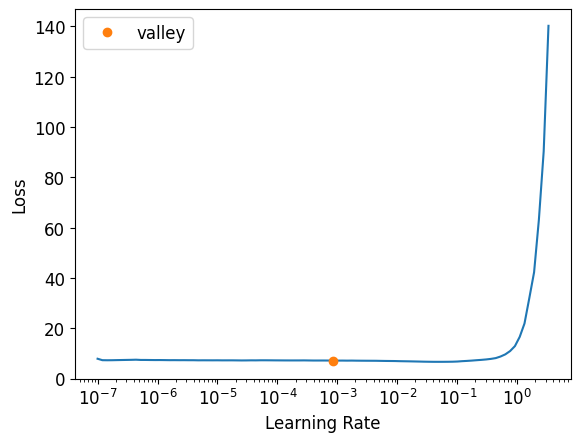

In [57]:
learn3.lr_find(stop_div=False)

Se usará un base_lr de $10^{-3}$, que internamente es el lr_max de fit_one_cycle. Se usará en las dos pruebas siguientes también.

In [58]:
es = EarlyStoppingCallback (min_delta=0.01, patience=5)
learn3.fine_tune(epochs = 3, base_lr = 0.001, cbs=es)

epoch,train_loss,valid_loss,accuracy,time
0,5.751005,3.661988,0.196995,00:39


epoch,train_loss,valid_loss,accuracy,time
0,4.224431,2.929754,0.313856,00:43
1,3.434485,2.386636,0.424040,00:39
2,3.098337,2.299676,0.425710,00:40


A pesar de que los resultados parecen buenos, se va a probar a dejar más épocas con las capas congeladas a ver si se mejoran los resultados. También se dejarán más épocas con el modelo sin congelar.

###SEGUNDO FINE TUNING

In [59]:
learn4 = vision_learner(deepcopy(dls_aug), resnet18, pretrained=True, metrics=accuracy, custom_head = head2, splitter = custom_splitter)


In [60]:
learn4.fine_tune(epochs = 10, base_lr = 0.001, cbs=es, freeze_epochs = 10)

epoch,train_loss,valid_loss,accuracy,time
0,6.966534,5.664629,0.006678,00:40
1,6.422347,5.001745,0.030050,00:38
2,5.554817,4.099135,0.106845,00:38
3,4.558364,3.192011,0.288815,00:40
4,3.808302,2.549284,0.388982,00:39
5,3.135735,2.157757,0.459098,00:38
6,2.675268,1.898815,0.485810,00:38
7,2.469891,1.805718,0.490818,00:41
8,2.147435,1.694164,0.519199,00:39
9,1.988042,1.611703,0.540901,00:39


epoch,train_loss,valid_loss,accuracy,time
0,1.741451,1.524531,0.590985,00:43
1,1.719323,1.471425,0.611018,00:40
2,1.655208,1.429092,0.604341,00:42
3,1.546196,1.396251,0.629382,00:41
4,1.482552,1.367212,0.624374,00:41
5,1.380566,1.336760,0.624374,00:43
6,1.271316,1.311667,0.629382,00:40
7,1.267062,1.296203,0.644407,00:42
8,1.190235,1.295967,0.642738,00:41
9,1.148402,1.296084,0.646077,00:40


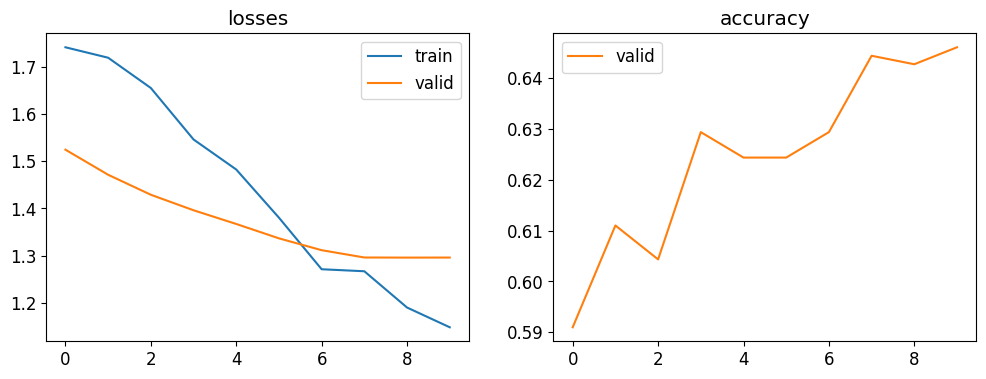

In [61]:
learn4.recorder.plot_metrics()

El accuracy va mejorando pero se produce un poco de overfitting. No obstante, todo parece indicar que este será el modelo elegido como final, así que se probará a dejar más épocas sin congelar a ver si sube un poco más el accuracy en validación.

###TERCER FINE TUNING

A continuación, se probará con otros valores de Learning Rates y se entrenará como en la ejecución anterior.

Se subirá el base_lr, que es el lr_max que se usa en el entreno con las capas congeladas y tambien el lr_mult, que es por lo que se divide la mitad de base_lr para el LR más pequeño del slice que se pasa para entrenar con la red descongelada.

In [62]:
learn5 = vision_learner(deepcopy(dls_aug), resnet18, pretrained=True, metrics=accuracy, custom_head = head3, splitter = custom_splitter)

In [63]:
learn5.fine_tune(epochs = 10, base_lr = 0.01, lr_mult = 1000, cbs=es, freeze_epochs = 10)

epoch,train_loss,valid_loss,accuracy,time
0,5.550363,3.660747,0.186978,00:41
1,3.806156,2.446502,0.398998,00:39
2,2.980987,2.066911,0.454090,00:40
3,2.627119,1.934764,0.475793,00:40
4,2.673312,2.099394,0.464107,00:39
5,2.563859,1.952916,0.494157,00:40
6,2.427536,1.725505,0.552588,00:41
7,2.230222,1.798332,0.540901,00:38
8,2.118606,1.668526,0.552588,00:39
9,1.989856,1.712049,0.544240,00:41


epoch,train_loss,valid_loss,accuracy,time
0,1.484392,1.392825,0.657763,00:40
1,1.385846,1.366665,0.636060,00:43
2,1.473117,1.348520,0.641068,00:41
3,1.317344,1.400118,0.627713,00:41
4,1.253306,1.378626,0.647746,00:42
5,1.131515,1.324126,0.667780,00:40
6,1.036170,1.306285,0.659432,00:43
7,0.964017,1.254966,0.681135,00:41
8,0.863437,1.251565,0.682805,00:42
9,0.809885,1.242784,0.682805,00:41


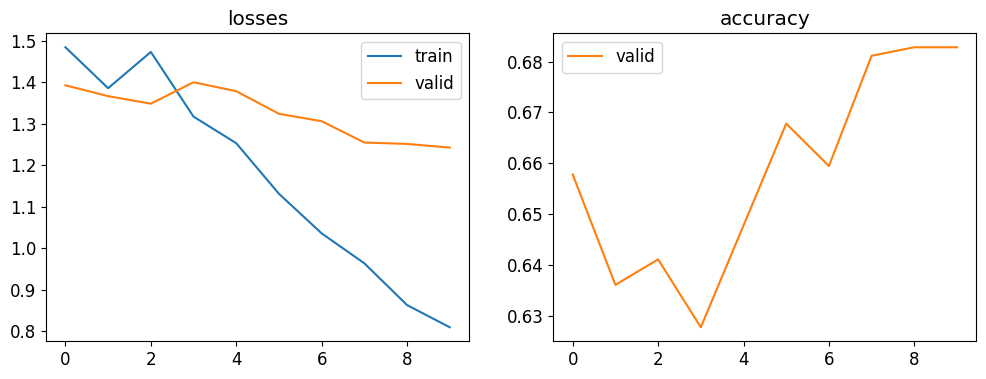

In [64]:
learn5.recorder.plot_metrics()

Se descarta esta idea. No se obtiene más rendimiento y el modelo se comporta de forma menos estable y se produce overfitting.

###FINE TUNING CON BS 128

A continuación se probará con un tamaño de batch de 128.

In [65]:
db_train_bs= DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 33),
    get_y = parent_label,
    item_tfms = Resize(224), # so our images have the same size as ImageNet images (the dataset in which ResNet18 was pretrained on)
    batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats), *aug_transforms(flip_vert = True)]
)
dls_bs  = db_train_bs.dataloaders(path/'train', bs=128)

In [66]:
head4 = create_head(512, 200)
print(head)

learn6 = vision_learner(deepcopy(dls_bs), resnet18, pretrained=True, metrics=accuracy, custom_head = head4, splitter = custom_splitter)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=200, bias=False)
)


SuggestedLRs(valley=0.001737800776027143)

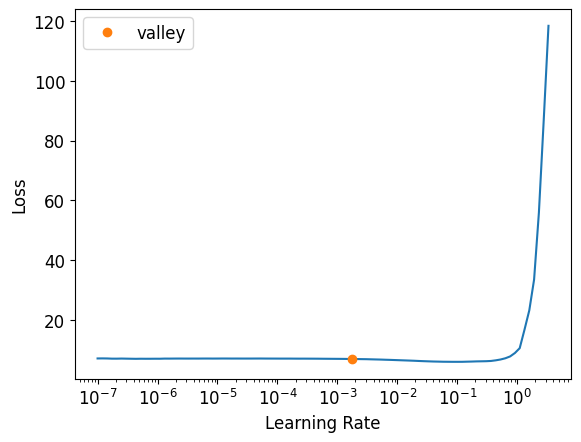

In [67]:
learn6.lr_find(stop_div = False)

Se usará un base_lr de $10^{-3}$

epoch,train_loss,valid_loss,accuracy,time
0,7.049778,5.839591,0.011686,00:38
1,6.878489,5.493783,0.011686,00:38
2,6.529787,4.881067,0.063439,00:39
3,5.981153,4.130754,0.155259,00:37
4,5.241537,3.384990,0.250417,00:37
5,4.502187,2.815174,0.335559,00:37
6,3.843030,2.412657,0.402337,00:38
7,3.307347,2.103392,0.450751,00:38
8,2.881886,1.897436,0.502504,00:37
9,2.552826,1.771832,0.547579,00:38


epoch,train_loss,valid_loss,accuracy,time
0,2.085295,1.746480,0.554257,00:39
1,2.053310,1.698941,0.575960,00:40
2,1.987255,1.635168,0.579299,00:39
3,1.878094,1.607202,0.574290,00:39
4,1.813071,1.560887,0.590985,00:41
5,1.720157,1.529272,0.589316,00:39
6,1.662878,1.498789,0.597663,00:39
7,1.579192,1.494059,0.606010,00:41
8,1.529395,1.485192,0.595993,00:39
9,1.519411,1.486307,0.606010,00:39


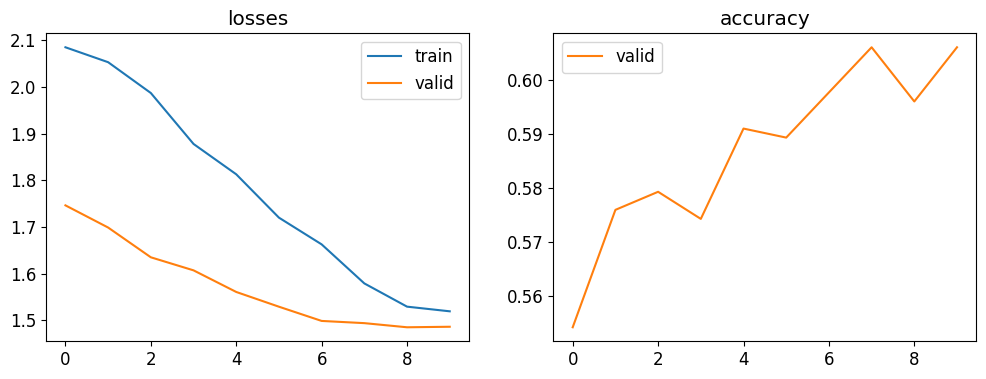

In [68]:
learn6.fine_tune(epochs = 10, base_lr = 0.001, cbs=es, freeze_epochs = 10)
learn6.recorder.plot_metrics()

El peor desempeño en Accuracy y la nula diferencia en los tiempos de entrenamiento por épocas hacen que se siga optando por el enfoque de un BS de 32.

## <font color='blue'>  3.3. Train from scratch the entire ResNet18 (including the suitable FC layer as output/head)

In [69]:
num_classes = 200
head = create_head(512, 200)
head1 = create_head(512, 200)

print(head)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=200, bias=False)
)


Como se va a entrenar desde cero, pretrained se pone a False y no se congela nada antes de entrenar.

SuggestedLRs(valley=0.0012022644514217973)

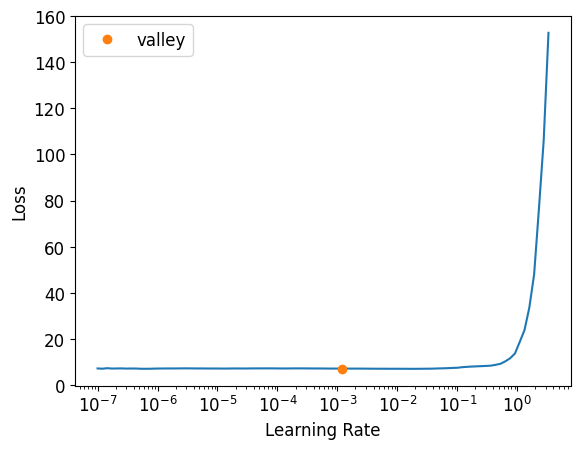

In [70]:
# Create a Fastai Learner
learn7 = vision_learner(deepcopy(dls_aug), resnet18, pretrained=False, train_bn=False, metrics=accuracy, custom_head = head, splitter = custom_splitter)
learn8 = vision_learner(deepcopy(dls_aug), resnet18, pretrained=False, train_bn=False, metrics=accuracy, custom_head = head1, splitter = custom_splitter)

learn7.lr_find(stop_div=False)

No se usará Early Stopping para que se muestre bien la curva de aprendizaje, como se verá a continuación, de todas las opciones que hemos explorado, esta es sin duda la peor. Parece lógico usar un LR Max de $10^{-2}$, justo antes de que la gráfica empiece a diverger.

epoch,train_loss,valid_loss,accuracy,time
0,6.299588,5.490320,0.005008,00:40
1,6.228170,5.652558,0.008347,00:43
2,6.120676,27.398411,0.008347,00:40
3,5.564254,5.670827,0.011686,00:42
4,4.899009,4.969430,0.021703,00:41
5,4.758863,4.707283,0.026711,00:40
6,4.657127,4.567137,0.036728,00:43
7,4.548497,4.449914,0.053422,00:40
8,4.414636,4.228471,0.063439,00:42
9,4.273433,4.177791,0.078464,00:40


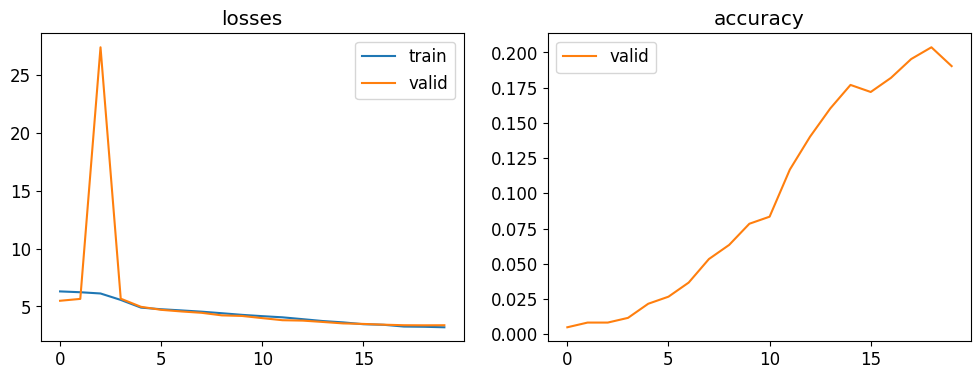

In [71]:
learn7.fit_one_cycle(20, lr_max=10**-2)
learn7.recorder.plot_metrics()

Como se puede observar, el entrenamiento se demora mucho, se produce overfitting y el accuracy logrado en Validación es muy bajo. Si estamos pensando en aprovechar un modelo preentrenado en una tarea parecida a la nuestra, esta idea es la menos indicada para aplicar, ya que pierde la esencia de lo que estamos haciendo.

No hay que olvidar que ResNet18 fue entrenada con Imagenet, un conjunto mucho más numeroso que el nuestro.

A mi parecer, la forma de proceder sería explorar distintas cabeceras acordes a nuestro problema y una vez determinada la mejor, aplicar fine_tuning.

Claramente, esto depende del problema que estemos tratando y, como se dijo en las partes 1 y 2 de la práctica, se podrían probar distintos métodos y parámetros que podrían mejorar el modelo. Desde parámetros de las funciones, a otra cabecera, etc.

Por último, para finalizar este apartado, se probará a hacer fine tune con el modelo sin preentrenar para ver lo que sucede. La intuición dice que si usamos fine_tune, que entrena con congelación y después sin ella, no vamos a obtener mejores resultados, puesto que los pesos congelados no provienen de un entrenamiento previo.

SuggestedLRs(valley=0.0010000000474974513)

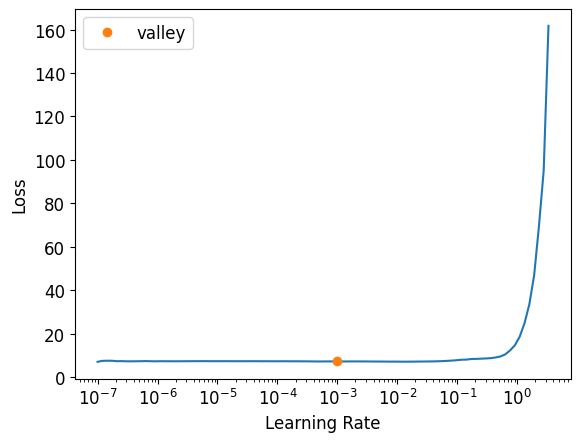

In [72]:
learn8.lr_find(stop_div=False)

El LR será $10^{-3}$

epoch,train_loss,valid_loss,accuracy,time
0,6.413002,5.547453,0.001669,00:38
1,6.253705,5.841187,0.020033,00:40
2,6.087362,6.200158,0.015025,00:38
3,5.503044,5.279467,0.016694,00:38
4,5.157407,5.119215,0.010017,00:38


epoch,train_loss,valid_loss,accuracy,time
0,4.845691,4.858595,0.025042,00:43
1,4.774032,4.745778,0.028381,00:40
2,4.567672,4.527793,0.038397,00:41
3,4.352551,4.384237,0.046745,00:41
4,4.191494,4.370358,0.048414,00:41


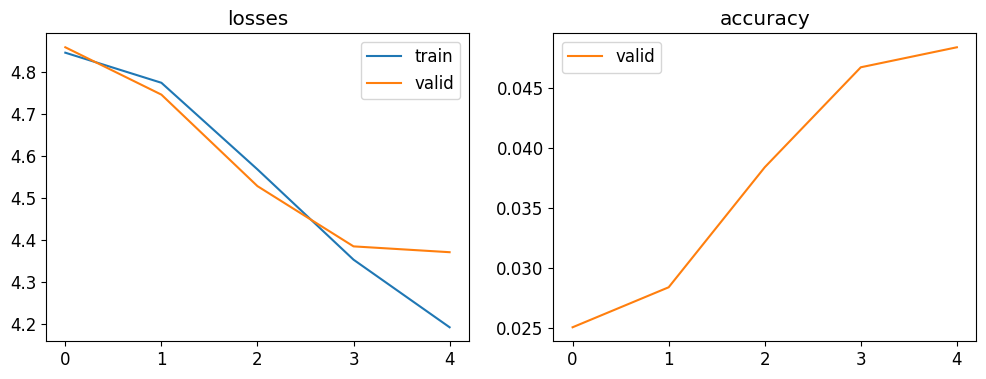

In [73]:
learn8.fine_tune(epochs = 5, base_lr=10**-2, cbs = es, freeze_epochs = 5)
learn8.recorder.plot_metrics()

Se han dejado 5 épocas por cada parte para no demorar demasiado esta prueba que a priori iba a ser mala, y así ha sido. Se obtienen peores resultados que entrenando desde cero con fit one cycle.

##TESTEO DEL MEJOR MODELO

A continuación se va a testear el mejor modelo. Para ello. se usará el entrenado en el segundo experimento del apartado 3.2.

Es decir, se usará data augmentation, train_bn se pone a True (viene así por defecto) y el BS es de 32. Además, dado que no se ha producido Early Stopping en esa prueba, se probará a dejar más épocas de entrenamiento con el modelo sin congelar (25 en vez de 10). Al igual que en las partes 1 y 2 de la práctica, se guardará el mejor modelo y se borrará de disco, puesto que al terminar el entrenamiento ya se carga en el learner automáticamente.

In [74]:
# Freeze the weights of the ResNet18 body
def custom_splitter(model):
    #Un grupo va del 0.0 al 0.7 y otro todos los que empiecen por 1, que es nuestra cabecera.
    return [params(model[0][:8]), params(model[1][:])]

db_train_aug= DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1, seed = 33),
    get_y = parent_label,
    item_tfms = Resize(224), # so our images have the same size as ImageNet images (the dataset in which ResNet18 was pretrained on)
    batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats), *aug_transforms(flip_vert = True)]
)
dls_aug  = db_train_aug.dataloaders(path/'train', bs=32)

head = create_head(512, 200)
learn_final = vision_learner(deepcopy(dls_aug), resnet18, pretrained=True, metrics=accuracy, custom_head = head, splitter = custom_splitter)

SuggestedLRs(valley=0.002511886414140463)

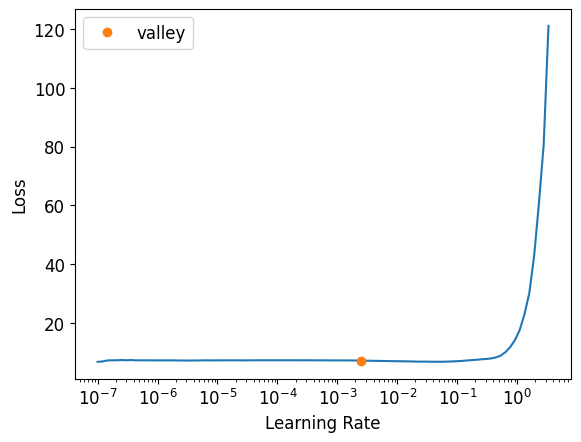

In [75]:
learn_final.lr_find(stop_div=False)

Se usará un LR de $10^{-3}$, como en la ejecución de prueba.

In [76]:
es = EarlyStoppingCallback (min_delta=0.01, patience=5)
sm = SaveModelCallback(min_delta = 0.01, fname="model_final")

learn_final.fine_tune(epochs = 25, base_lr = 0.001, cbs=[es,sm], freeze_epochs = 10)

epoch,train_loss,valid_loss,accuracy,time
0,6.931763,5.684189,0.013356,00:39
1,6.366345,5.045086,0.046745,00:39
2,5.592738,4.125156,0.146912,00:41
3,4.595729,3.251670,0.273790,00:39
4,3.815043,2.574701,0.398998,00:38
5,3.178980,2.171908,0.457429,00:41
6,2.759624,1.933732,0.480801,00:39
7,2.411491,1.729074,0.542571,00:39
8,2.193949,1.644348,0.549249,00:40
9,2.021179,1.544070,0.574290,00:40


Better model found at epoch 0 with valid_loss value: 5.684189319610596.
Better model found at epoch 1 with valid_loss value: 5.04508638381958.
Better model found at epoch 2 with valid_loss value: 4.125156402587891.
Better model found at epoch 3 with valid_loss value: 3.2516696453094482.
Better model found at epoch 4 with valid_loss value: 2.5747008323669434.
Better model found at epoch 5 with valid_loss value: 2.171907663345337.
Better model found at epoch 6 with valid_loss value: 1.9337321519851685.
Better model found at epoch 7 with valid_loss value: 1.7290737628936768.
Better model found at epoch 8 with valid_loss value: 1.6443482637405396.
Better model found at epoch 9 with valid_loss value: 1.544069528579712.


epoch,train_loss,valid_loss,accuracy,time
0,1.734289,1.487024,0.585977,00:40
1,1.674510,1.452041,0.607679,00:43
2,1.633951,1.439614,0.607679,00:41
3,1.590402,1.409245,0.604341,00:42
4,1.525969,1.362777,0.642738,00:42
5,1.442338,1.371005,0.622705,00:41
6,1.451150,1.366356,0.627713,00:42
7,1.356664,1.290878,0.637730,00:40
8,1.267262,1.295795,0.632721,00:43
9,1.229852,1.286168,0.636060,00:40


Better model found at epoch 0 with valid_loss value: 1.4870244264602661.
Better model found at epoch 1 with valid_loss value: 1.4520409107208252.
Better model found at epoch 2 with valid_loss value: 1.4396138191223145.
Better model found at epoch 3 with valid_loss value: 1.4092445373535156.
Better model found at epoch 4 with valid_loss value: 1.3627772331237793.
Better model found at epoch 7 with valid_loss value: 1.2908779382705688.
Better model found at epoch 11 with valid_loss value: 1.2764074802398682.
Better model found at epoch 12 with valid_loss value: 1.2520489692687988.
Better model found at epoch 13 with valid_loss value: 1.239277958869934.
Better model found at epoch 15 with valid_loss value: 1.2267674207687378.
Better model found at epoch 16 with valid_loss value: 1.2125272750854492.
Better model found at epoch 20 with valid_loss value: 1.1893799304962158.


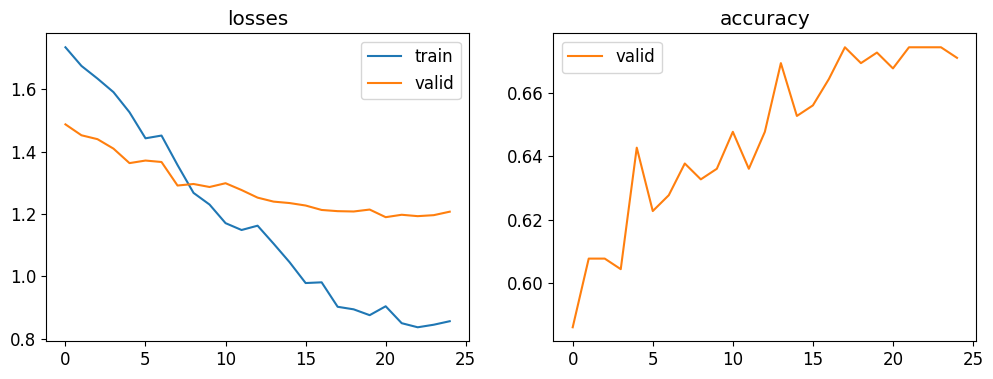

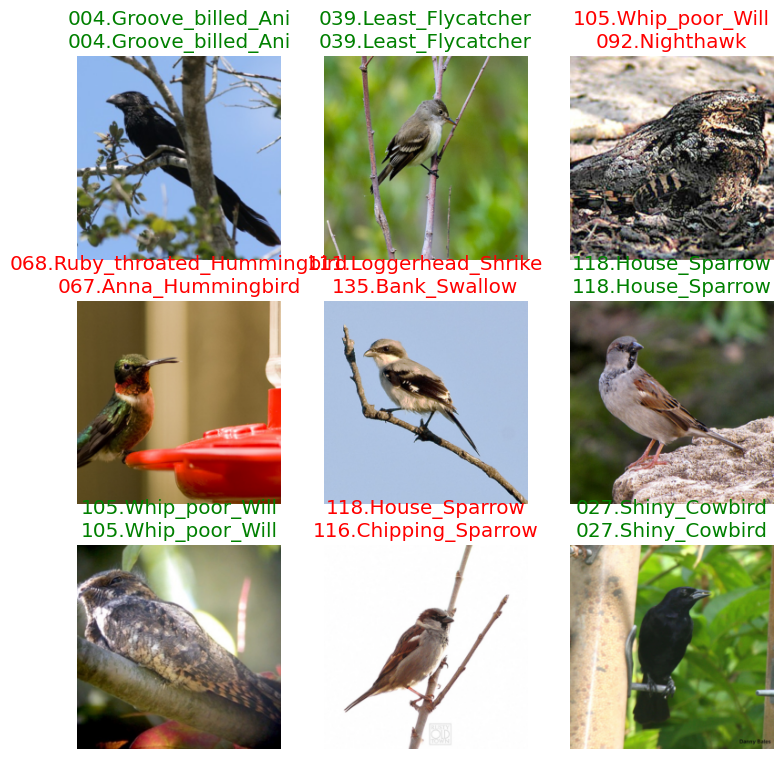

In [77]:
learn_final.recorder.plot_metrics()

learn_final.show_results()

Se ha producido overfitting. No obstante, se ha obtenido el mayor accuracy en validación de todas las pruebas que se han hecho. Si se quisiera mejorar, habría que abordar este hecho o cambiar el enfoque desde el principio.

In [78]:
if os.path.exists("/content/models/model_final.pth"):
    # Borrar el archivo
    os.remove("/content/models/model_final.pth")

Con esto se borra el modelo de disco.

In [79]:
#We perform prediction on this bunch of data (in this case, the validation set)
test_files = [fn for fn in sorted((path/'test').glob('**/*')) if fn.is_file()]
test_dl = learn_final.dls.test_dl(test_files,with_labels=True)

preds, targs, _ = learn_final.get_preds(dl=test_dl, with_decoded=True)
preds2, targs2, _ = learn_final.get_preds(dl=learn_final.dls.train, with_decoded=True)
preds3, targs3, _ = learn_final.get_preds(dl=learn_final.dls.valid, with_decoded=True)
# We compute accuracy
acc_test = accuracy(preds, targs)
acc_train = accuracy(preds2,targs2)
acc_valid = accuracy(preds3, targs3)
print('The test accuracy is : ', round(float(acc_test)*100, 4), '%')
print('The train accuracy is : ', round(float(acc_train)*100, 4), '%')
print('The validation accuracy is : ', round(float(acc_valid)*100, 4), '%')

The test accuracy is :  68.0014 %
The train accuracy is :  90.7692 %
The validation accuracy is :  66.778 %


Dado el overfitting, el accuracy en train es mucho mayor que en test y validación. No obstante, en test se comporta como se esperaba según las pruebas en validación. Se descarta el uso de matrices de confusión dado el gran número de clases que se tiene. El accuracy logrado es un poco pobre. A mi parecer, se podría probar con otra red preentrenada y ver si obtiene mejores resultados. También se pueden hacer muchas más pruebas con ResNet18 al estilo de la parte 2 de la práctica (cambiar optimizador, inicializar pesos, etc). No obstante, se ha logrado demostrar las ventajas de usar un modelo preentrenado a entrenarlo desde 0.